In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 50

In [3]:
dataset_path = "/kaggle/input/breast-cancer-data/augmented_data"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1966 files belonging to 4 classes.


In [4]:
def get_dataset_partitions_tf(ds, train_split = 0.80, val_split =0.1 , test_split =0.1,shuffle = True ,shuffle_size = 10000 ):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds , val_ds,test_ds

In [5]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size  =AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size  =AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [10]:
initial_learning_rate = 0.001
dropout_rate = 0.5
weight_decay = 0.0001
patience = 5
factor = 0.5

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model3 = models.Sequential([
    base_model,
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.BatchNormalization(), 
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Dense(n_classes, activation='softmax')

])

model3.build(input_shape = input_shape)

In [12]:
model3.compile(optimizer = 'adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
#checkpoint to save best model per epoch
model_filepath = "/content/drive/MyDrive/model/model3v2/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    verbose=1
)

callbacks_list = [checkpoint, early_stopping]

In [14]:
import time

# Record the start time
start_time = time.time()

In [15]:
history3 = model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs =50,
    callbacks=[early_stopping]
)

Epoch 1/50
98/98 [==============================] - 158s 1s/step - loss: 1.5738 - accuracy: 0.3040 - val_loss: 1.4892 - val_accuracy: 0.2917
Epoch 2/50
98/98 [==============================] - 87s 883ms/step - loss: 1.5019 - accuracy: 0.3078 - val_loss: 1.4996 - val_accuracy: 0.3125
Epoch 3/50
98/98 [==============================] - 86s 880ms/step - loss: 1.4521 - accuracy: 0.3321 - val_loss: 1.4816 - val_accuracy: 0.3177
Epoch 4/50
98/98 [==============================] - 86s 880ms/step - loss: 1.4133 - accuracy: 0.3455 - val_loss: 1.7594 - val_accuracy: 0.2708
Epoch 5/50
98/98 [==============================] - 86s 877ms/step - loss: 1.3679 - accuracy: 0.4010 - val_loss: 1.6750 - val_accuracy: 0.2969
Epoch 6/50
98/98 [==============================] - 86s 876ms/step - loss: 1.3509 - accuracy: 0.4068 - val_loss: 1.5289 - val_accuracy: 0.3125
Epoch 7/50
98/98 [==============================] - 86s 877ms/step - loss: 1.3244 - accuracy: 0.4285 - val_loss: 1.3605 - val_accuracy: 0.4115
E

In [16]:
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 2471.8723108768463 seconds


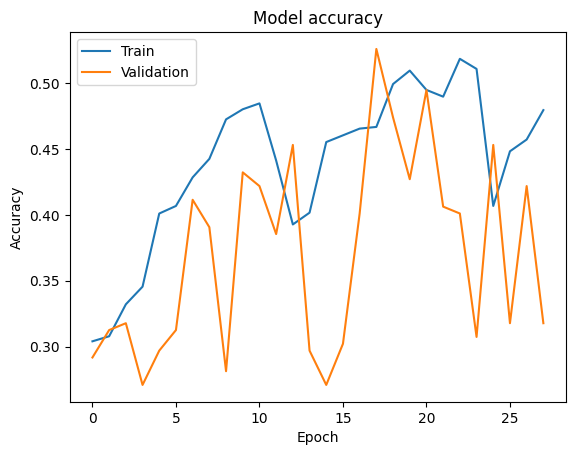

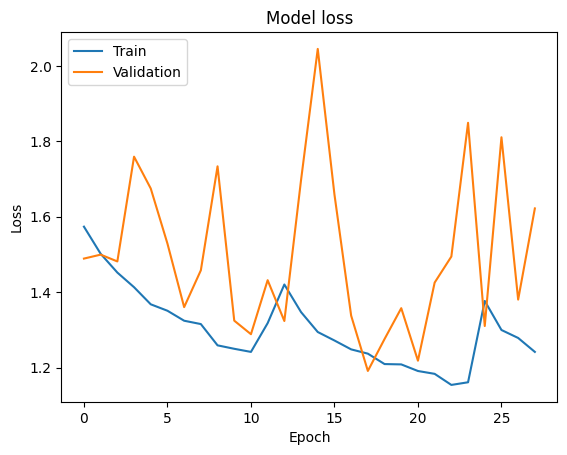

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
class_names = dataset.class_names
class_names

['Benign', 'InSitu', 'Invasive', 'Normal']

In [19]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming class_names is a list containing the names of your classes
class_names = class_names

# Get predictions on the test set
predictions = model3.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels_ds = test_ds.map(lambda x, y: y)
true_labels = np.concatenate(list(true_labels_ds.as_numpy_iterator()))

# Print classification report with class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


13/13 [==============================] - 17s 382ms/step
              precision    recall  f1-score   support

      Benign       0.25      0.10      0.15        48
      InSitu       0.45      0.18      0.26        49
    Invasive       0.29      0.98      0.45        49
      Normal       0.50      0.02      0.03        62

    accuracy                           0.30       208
   macro avg       0.37      0.32      0.22       208
weighted avg       0.38      0.30      0.21       208

